## ERROR ANALYSIS

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Add the root directory to path so we can import src
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.utils import load_params
from src.preprocessing import clean_data, feature_engineering, split_data
from src.data_loader import load_and_merge

# 2. Load Resources
print("Loading Data and Model...")
config = load_params()
df = load_and_merge('../data/train.csv', '../data/store.csv')

# Clean & Engineer
df = clean_data(df)
df = feature_engineering(df)

# Split (Errors are analyzed on the CV and Test set, not the Train set)
X_train, y_train, X_cv, y_cv, X_test, y_test = split_data(df)

# Load the Best Model
model_type = config['models']['type']
model_path = f"../models/{model_type}.pkl" 
model = joblib.load(model_path)
print(f"Loaded {model_type} from {model_path}")

# 3. Make Predictions
print("Predicting...")
y_pred = model.predict(X_cv)

# 4. Create an Error Analysis DataFrame
analysis_df = X_cv.copy()
analysis_df['Actual_Sales'] = y_cv
analysis_df['Predicted_Sales'] = y_pred
analysis_df['Error'] = analysis_df['Actual_Sales'] - analysis_df['Predicted_Sales']
analysis_df['Abs_Error'] = abs(analysis_df['Error'])
analysis_df['Error_Percentage'] = (analysis_df['Abs_Error'] / analysis_df['Actual_Sales']) * 100

print("Analysis Data is ready.")

Loading Data and Model...
Loaded XGBoost from ../models/XGBoost.pkl
Predicting...
Analysis Data is ready.


## Analysis 1: Top Failures
Shows the rows where the model failed the hardest.

In [6]:
# Reconstruct the 'Date' column from Year, Month, Day for visualization
if 'Date' not in analysis_df.columns:
    analysis_df['Date'] = pd.to_datetime(analysis_df[['Year', 'Month', 'Day']])

# Now run the sorting and display code
worst_predictions = analysis_df.sort_values(by='Abs_Error', ascending=False).head(10)

print("Top 10 Worst Predictions:")
display(worst_predictions[['Store', 'Date', 'Actual_Sales', 'Predicted_Sales', 'Abs_Error', 'Error_Percentage', 'Promo', 'StateHoliday']])

Top 10 Worst Predictions:


,Store,Date,Actual_Sales,Predicted_Sales,Abs_Error,Error_Percentage,Promo,StateHoliday
685812,644,2015-02-10,28242,7154.511719,21087.488281,74.667121,0,0
686927,644,2015-02-11,26818,7042.944824,19775.055176,73.737994,0,0
684697,644,2015-02-09,22970,7245.901855,15724.098145,68.454933,0,0
653531,699,2015-01-07,24338,8826.154297,15511.845703,63.735088,1,0
691537,831,2015-02-16,3686,17849.371094,14163.371094,384.247724,1,0
679153,674,2015-02-03,24868,10922.309570,13945.690430,56.078858,1,0
688041,644,2015-02-12,20645,7209.408691,13435.591309,65.079154,0,0
678039,674,2015-02-02,25748,12600.898438,13147.101562,51.060671,1,0
691610,756,2015-02-16,6509,19390.246094,12881.246094,197.899003,1,0
652380,699,2015-01-06,22911,10502.822266,12408.177734,54.158167,1,0


## Analysis 2: Systematic Bias
Shows the distribution of errors. Is the model generally guessing too high or too low?

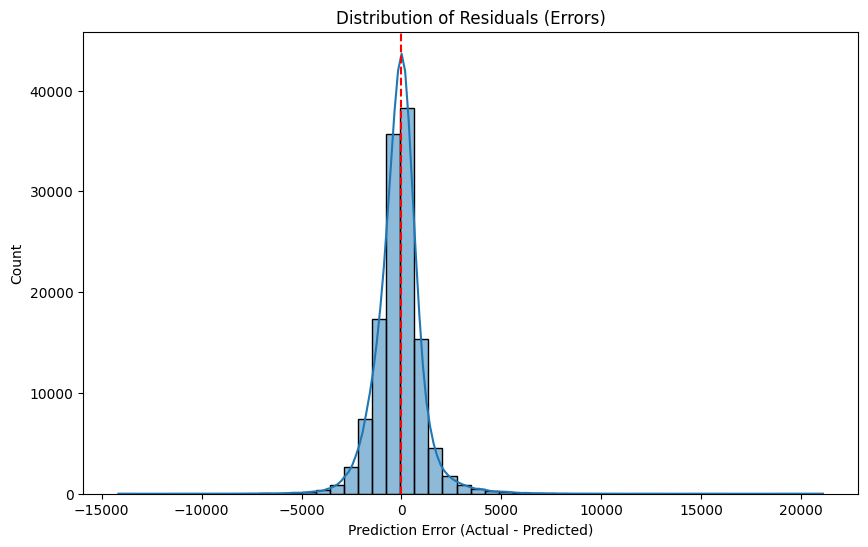

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(analysis_df['Error'], kde=True, bins=50)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Distribution of Residuals (Errors)")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.show()

## Analysis 3: Diagnosing Failure modes
Shows if the specific contexts where the model fails.

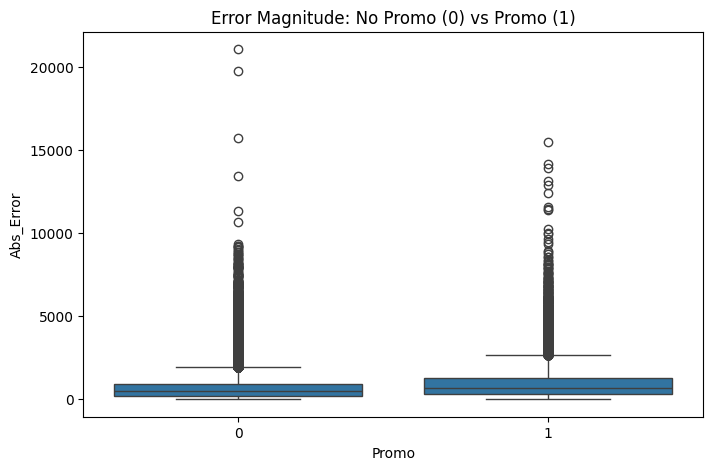

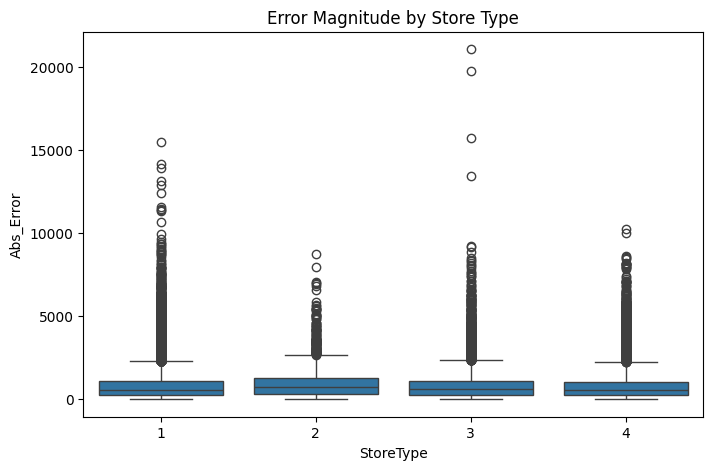

In [5]:
# Error by Promo (Does Promo confuse the model?)
plt.figure(figsize=(8, 5))
sns.boxplot(x='Promo', y='Abs_Error', data=analysis_df)
plt.title("Error Magnitude: No Promo (0) vs Promo (1)")
plt.show()

# Error by Store Type
plt.figure(figsize=(8, 5))
sns.boxplot(x='StoreType', y='Abs_Error', data=analysis_df)
plt.title("Error Magnitude by Store Type")
plt.show()